## Applying player tracking and homography

## Install dependencjes

In [28]:
!pip install -q gdown inference-gpu
!pip install -q onnxruntime-gpu==1.18.0 --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/onnxruntime-cuda-12/pypi/simple/

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-cpu 0.16.3 requires opencv-python<=4.8.0.76, but you have opencv-python 4.10.0.84 which is incompatible.


^C


In [2]:
!pip install -q git+https://github.com/roboflow/sports.git

In [3]:
!pip uninstall -y supervision && pip install -q supervision>=0.23.0

Found existing installation: supervision 0.22.0
Uninstalling supervision-0.22.0:
  Successfully uninstalled supervision-0.22.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-cpu 0.16.3 requires opencv-python<=4.8.0.76, but you have opencv-python 4.10.0.84 which is incompatible.
inference-cpu 0.16.3 requires supervision<=0.22.0,>=0.20.0, but you have supervision 0.24.0 which is incompatible.
inference-gpu 0.22.2 requires supervision<=0.22.0,>=0.21.0, but you have supervision 0.24.0 which is incompatible.


In [29]:
import os
os.environ["ONNXRUNTIME_EXECUTION_PROVIDERS"] = "[CUDAExecutionProvider]"

# Image In Question

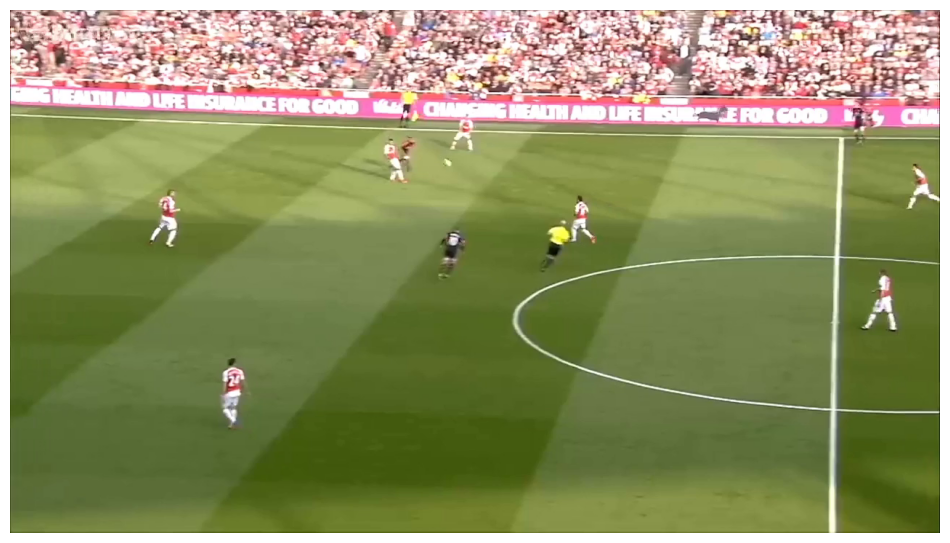

In [38]:
import supervision as sv

SOURCE_VIDEO_PATH = "data/ozil_goal_cut.mp4"

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

sv.plot_image(frame)

## Testing Player Detection Model

In [31]:
# !pip install --upgrade inference
from inference import get_model

ROBOFLOW_API_KEY = 'g0kReC3ubPe9dTtlz7uN'
PLAYER_DETECTION_MODEL_ID = "arsenal-players/2"
PLAYER_DETECTION_MODEL = get_model(model_id=PLAYER_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

Detections(xyxy=array([[135., 215., 171., 274.],
       [513., 210., 559., 272.],
       [268., 266., 322., 335.]]), mask=None, confidence=array([0.96162581, 0.94509757, 0.83226168]), class_id=array([6, 7, 4]), tracker_id=None, data={'class_name': array(['sanchez', 'walcott', 'ozil'], dtype='<U7')})
['bellerin', 'cazorla', 'coquelin', 'mustafi', 'ozil', 'ramsey', 'sanchez', 'walcott']


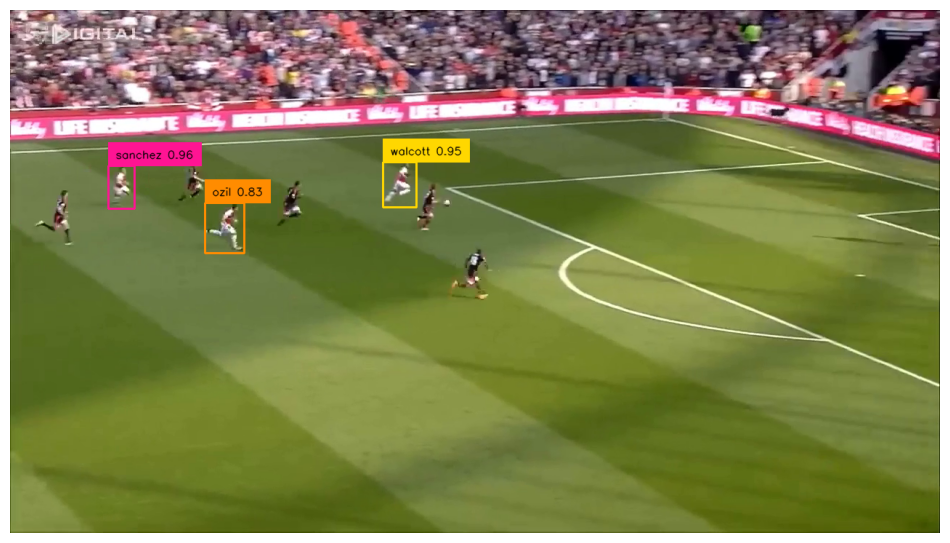

In [32]:
# import supervision as sv

# SOURCE_VIDEO_PATH = "/content/ozil_goal_cut.mp4"

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)
print(detections)
print(PLAYER_DETECTION_MODEL.class_names)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

## Test Pitch Detection Model

In [40]:
from inference import get_model

# FIELD_DETECTION_MODEL_ID = "pitch-detector-aq9zg/2"
FIELD_DETECTION_MODEL_ID = "football-field-detection-f07vi/14"
FIELD_DETECTION_MODEL = get_model(model_id=FIELD_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

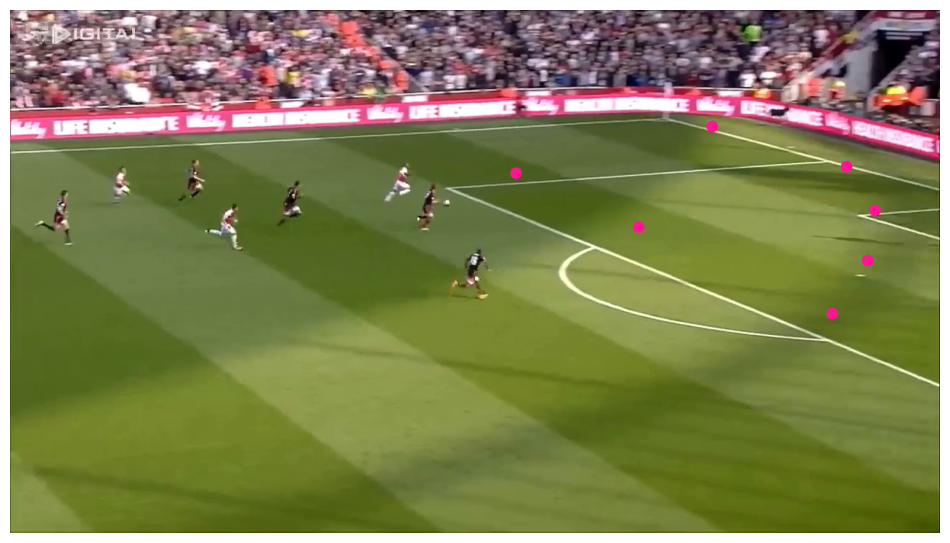

In [42]:
import numpy as np

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)

filter = key_points.confidence[0] > 0.5
# print(filter)
frame_reference_points = key_points.xy[0][filter]

frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## Test Ball Detections

In [35]:
BALL_DETECTION_MODEL_ID = "ball-detection-yqhcn/1"
BALL_DETECTION_MODEL = get_model(model_id=BALL_DETECTION_MODEL_ID, api_key=ROBOFLOW_API_KEY)

Detections(xyxy=array([[592., 202., 613., 223.]]), mask=None, confidence=array([0.8348161]), class_id=array([0]), tracker_id=None, data={'class_name': array(['ball'], dtype='<U4')})


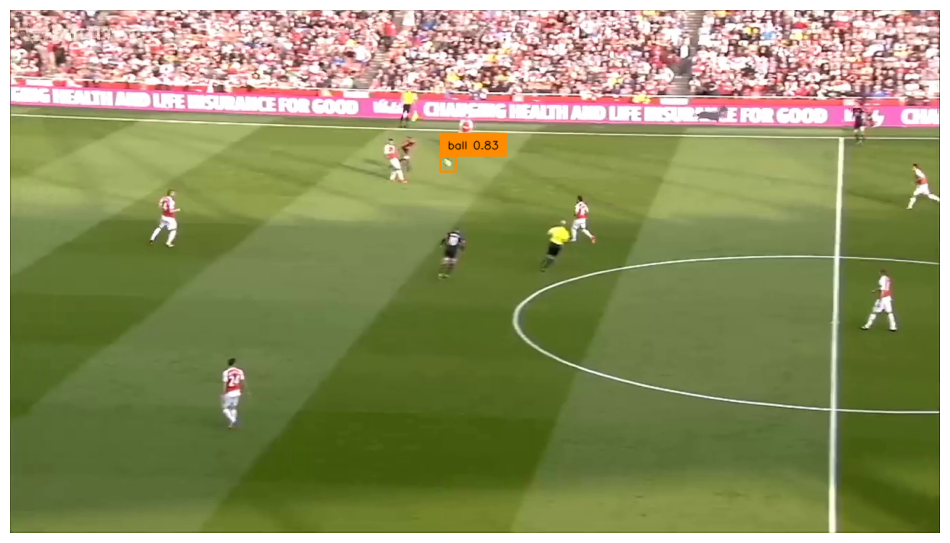

In [36]:
box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
frame = next(frame_generator)

result = BALL_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)
print(detections)

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

## Testing the transformer

KeyPoints(xy=array([[[ 128.,  169.],
        [   0.,  223.],
        [   0.,  279.],
        [   0.,  453.],
        [   0.,  501.],
        [ 613.,  435.],
        [   0.,  296.],
        [   0.,  439.],
        [   0.,  380.],
        [ 319.,  225.],
        [ 205.,  319.],
        [   0.,  447.],
        [   0.,  622.],
        [  48.,  202.],
        [  40.,  333.],
        [  25.,  517.],
        [   3.,  720.],
        [ 696.,  225.],
        [ 865.,  299.],
        [1131.,  418.],
        [1280.,  551.],
        [1180.,  345.],
        [1190.,  276.],
        [1280.,  405.],
        [ 966.,  161.],
        [1151.,  216.],
        [1280.,  271.],
        [1280.,  394.],
        [1280.,  481.],
        [1280.,  633.],
        [   0.,  427.],
        [ 154.,  410.]]], dtype=float32), class_id=array([0]), confidence=array([[2.1636486e-05, 1.4305115e-06, 2.0861626e-07, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 5.9604645e-07, 0.0000000e+00,
        6.8545341e-07, 1.7583370e

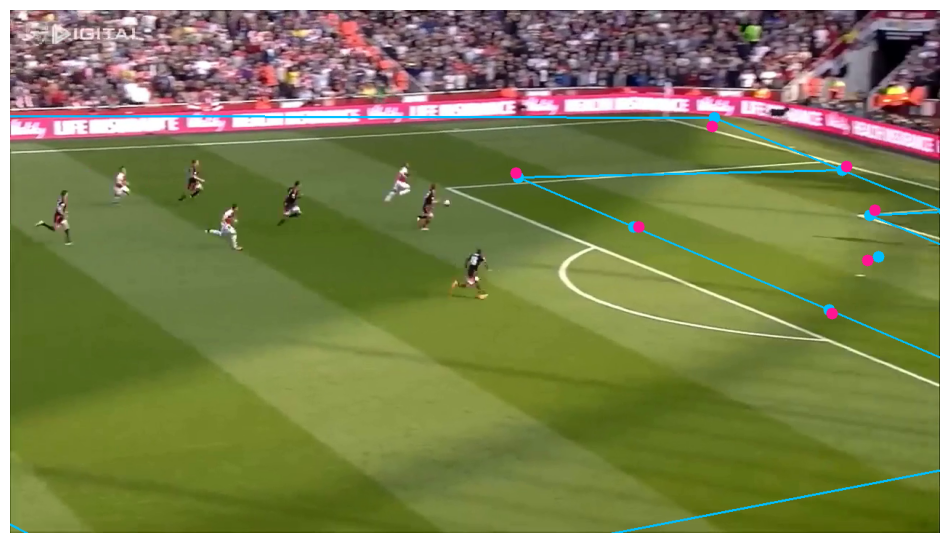

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inference-gpu 0.22.2 requires onnxruntime-gpu~=1.15.1, but you have onnxruntime-gpu 1.18.0 which is incompatible.


In [43]:
import numpy as np
import supervision as sv
from sports.common.view import ViewTransformer
from sports.annotators.soccer import draw_pitch
from sports.configs.soccer import SoccerPitchConfiguration

CONFIG = SoccerPitchConfiguration()

edge_annotator = sv.EdgeAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    thickness=2, edges=CONFIG.edges)
vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)
vertex_annotator_2 = sv.VertexAnnotator(
    color=sv.Color.from_hex('#00BFFF'),
    radius=8)

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)
print(key_points)

filter = key_points.confidence[0] > 0.5
print(len(key_points.confidence[0]))
frame_reference_points = key_points.xy[0][filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

pitch_reference_points = np.array(CONFIG.vertices)[filter]
print(len(np.array(CONFIG.vertices)))

transformer = ViewTransformer(
    source=pitch_reference_points,
    target=frame_reference_points
)

pitch_all_points = np.array(CONFIG.vertices)
frame_all_points = transformer.transform_points(points=pitch_all_points)

frame_all_key_points = sv.KeyPoints(xy=frame_all_points[np.newaxis, ...])

annotated_frame = frame.copy()
annotated_frame = edge_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator_2.annotate(
    scene=annotated_frame,
    key_points=frame_all_key_points)
annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

sv.plot_image(annotated_frame)

## Detect players, ball and pitch key-points and project onto a 2D plain

In [76]:
import cv2
from typing import Optional, List

# edited draw_points_on_pitch() method with circle labels
def draw_points_on_pitch(
    config: SoccerPitchConfiguration,
    xy: np.ndarray,
    face_color: sv.Color = sv.Color.RED,
    edge_color: sv.Color = sv.Color.BLACK,
    radius: int = 10,
    thickness: int = 2,
    padding: int = 50,
    scale: float = 0.1,
    pitch: Optional[np.ndarray] = None,
    labels: Optional[List[str]] = None,  # New parameter for labels
    font_scale: float = 0.7,  # Font size for labels
    font_thickness: int = 2,  # Thickness for the label text
    font_color: sv.Color = sv.Color.BLACK  # Color of the label text
) -> np.ndarray:
    """
    Draws points on a soccer pitch with optional labels underneath the points.

    Args:
        config (SoccerPitchConfiguration): Configuration object containing the
            dimensions and layout of the pitch.
        xy (np.ndarray): Array of points to be drawn, with each point represented by
            its (x, y) coordinates.
        face_color (sv.Color, optional): Color of the point faces.
            Defaults to sv.Color.RED.
        edge_color (sv.Color, optional): Color of the point edges.
            Defaults to sv.Color.BLACK.
        radius (int, optional): Radius of the points in pixels.
            Defaults to 10.
        thickness (int, optional): Thickness of the point edges in pixels.
            Defaults to 2.
        padding (int, optional): Padding around the pitch in pixels.
            Defaults to 50.
        scale (float, optional): Scaling factor for the pitch dimensions.
            Defaults to 0.1.
        pitch (Optional[np.ndarray], optional): Existing pitch image to draw points on.
            If None, a new pitch will be created. Defaults to None.
        labels (Optional[List[str]], optional): List of labels corresponding to each point.
            Defaults to None.
        font_scale (float, optional): Font scale for the label text. Defaults to 0.5.
        font_thickness (int, optional): Thickness of the label text. Defaults to 1.
        font_color (sv.Color, optional): Color of the label text. Defaults to sv.Color.WHITE.

    Returns:
        np.ndarray: Image of the soccer pitch with points and optional labels drawn on it.
    """
    if pitch is None:
        pitch = draw_pitch(
            config=config,
            padding=padding,
            scale=scale
        )

    for idx, point in enumerate(xy):
        scaled_point = (
            int(point[0] * scale) + padding,
            int(point[1] * scale) + padding
        )
        
        # Draw the circle
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=face_color.as_bgr(),
            thickness=-1
        )
        cv2.circle(
            img=pitch,
            center=scaled_point,
            radius=radius,
            color=edge_color.as_bgr(),
            thickness=thickness
        )
        
        # Draw the label if provided
        if labels is not None and idx < len(labels):
            label_text = labels[idx]
            
            # Get the text size to center the label
            text_size = cv2.getTextSize(
                text=label_text, 
                fontFace=cv2.FONT_HERSHEY_SIMPLEX, 
                fontScale=font_scale, 
                thickness=font_thickness
            )[0]
            
            # Adjust the label position to be center-aligned with the point
            label_position = (
                int(scaled_point[0] - text_size[0] / 2),  # Adjust x to be center aligned
                int(scaled_point[1] + radius + text_size[1] + 10)  # Place text under the circle
            )
            
            cv2.putText(
                img=pitch,
                text=label_text,
                org=label_position,
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=font_scale,
                color=font_color.as_bgr(),
                thickness=font_thickness
            )

    return pitch

KeyPoints(xy=array([[[ 128.,  169.],
        [   0.,  223.],
        [   0.,  279.],
        [   0.,  453.],
        [   0.,  501.],
        [ 613.,  435.],
        [   0.,  296.],
        [   0.,  439.],
        [   0.,  380.],
        [ 319.,  225.],
        [ 205.,  319.],
        [   0.,  447.],
        [   0.,  622.],
        [  48.,  202.],
        [  40.,  333.],
        [  25.,  517.],
        [   3.,  720.],
        [ 696.,  225.],
        [ 865.,  299.],
        [1131.,  418.],
        [1280.,  551.],
        [1180.,  345.],
        [1190.,  276.],
        [1280.,  405.],
        [ 966.,  161.],
        [1151.,  216.],
        [1280.,  271.],
        [1280.,  394.],
        [1280.,  481.],
        [1280.,  633.],
        [   0.,  427.],
        [ 154.,  410.]]], dtype=float32), class_id=array([0]), confidence=array([[2.1636486e-05, 1.4305115e-06, 2.0861626e-07, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 5.9604645e-07, 0.0000000e+00,
        6.8545341e-07, 1.7583370e

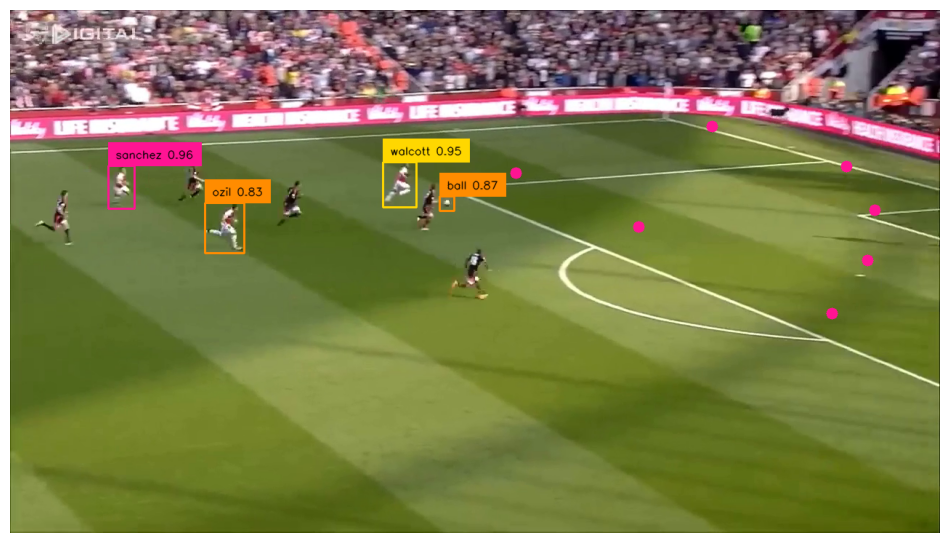

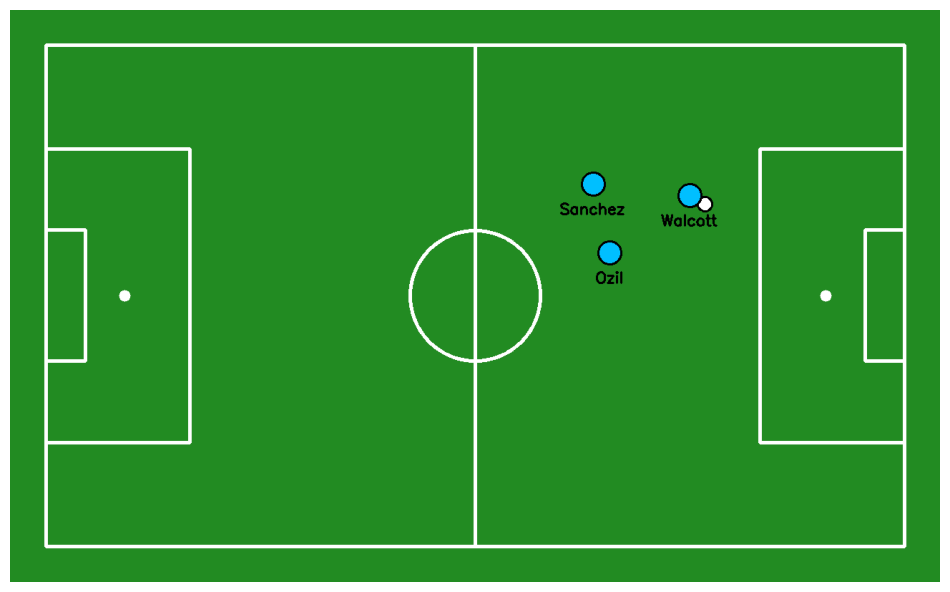

In [79]:
from sports.common.view import ViewTransformer
from sports.annotators.soccer import (
    draw_pitch,
    # draw_points_on_pitch
)
import cv2

frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH, start=200)
frame = next(frame_generator)

# class ids
BALL_ID = 0
RAMSEY_ID = 5
BELLERIN_ID = 0
COQ_ID = 2
CAZORLA_ID = 1
MUSTAFI_ID = 3
SANCHEZ_ID = 6
WALCOTT_ID = 7
OZIL_ID = 4
# player_ids = {
#     "RAMSEY_ID": 5,
#     "BELLERIN_ID": 0,
#     "COQ_ID": 2,
#     "CAZORLA_ID": 1,
#     "MUSTAFI_ID": 3,
#     "SANCHEZ_ID": 6,
#     "WALCOTT_ID": 7,
#     "OZIL_ID": 4
# }
player_detections = []


result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)
ramsey_detections = detections[detections.class_id == RAMSEY_ID]
bellerin_detections = detections[detections.class_id == BELLERIN_ID]
coq_detections = detections[detections.class_id == COQ_ID]
cazorla_detections = detections[detections.class_id == CAZORLA_ID]
mustafi_detections = detections[detections.class_id == MUSTAFI_ID]
sanchez_detections = detections[detections.class_id == SANCHEZ_ID]
walcott_detections = detections[detections.class_id == WALCOTT_ID]
ozil_detections = detections[detections.class_id == OZIL_ID]


# for i in player_ids:
#     player_detections.append(detections[detections.class_id == player_ids[i]])

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = frame.copy()
annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

vertex_annotator = sv.VertexAnnotator(
    color=sv.Color.from_hex('#FF1493'),
    radius=8)

result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
key_points = sv.KeyPoints.from_inference(result)
print(key_points)

filter = key_points.confidence[0] > 0.5
frame_reference_points = key_points.xy[0][filter]
pitch_reference_points = np.array(CONFIG.vertices)[filter]
frame_reference_key_points = sv.KeyPoints(
    xy=frame_reference_points[np.newaxis, ...])

transformer = ViewTransformer(
    source=frame_reference_points,
    target=pitch_reference_points
)

annotated_frame = vertex_annotator.annotate(
    scene=annotated_frame,
    key_points=frame_reference_key_points)

box_annotator = sv.BoxAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    thickness=2
)
label_annotator = sv.LabelAnnotator(
    color=sv.ColorPalette.from_hex(['#FF8C00', '#00BFFF', '#FF1493', '#FFD700']),
    text_color=sv.Color.from_hex('#000000')
)

result = BALL_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
detections = sv.Detections.from_inference(result)
ball_detections = detections[detections.class_id == 0]

labels = [
    f"{class_name} {confidence:.2f}"
    for class_name, confidence
    in zip(detections['class_name'], detections.confidence)
]

annotated_frame = box_annotator.annotate(
    scene=annotated_frame,
    detections=detections)
annotated_frame = label_annotator.annotate(
    scene=annotated_frame,
    detections=detections,
    labels=labels)

sv.plot_image(annotated_frame)

### PROJECT PLAYERS AND BALL ONTO 2D PLANE ####

frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ball_xy,
    face_color=sv.Color.WHITE,
    edge_color=sv.Color.BLACK,
    radius=10,
    pitch=annotated_frame)

# Ramsey
if ramsey_detections:
    ramsey_xy = ramsey_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ramsey_xy = transformer.transform_points(points=ramsey_xy)
    # plot ramsey on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ramsey_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Ramsey'])


# Bellerin
if bellerin_detections:
    bellerin_xy = bellerin_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_bellerin_xy = transformer.transform_points(points=bellerin_xy)
    # plot bellerin on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_bellerin_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Bellerin'])

# Coquelin
if coq_detections:
    coq_xy = coq_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_coq_xy = transformer.transform_points(points=coq_xy)
    # plot coquelin on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_coq_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Coquelin'])

# Cazorla
if cazorla_detections:
    cazorla_xy = cazorla_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_cazorla_xy = transformer.transform_points(points=cazorla_xy)
    # plot cazorla on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_cazorla_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Cazorla'])
    

# Mustafi
if mustafi_detections:
    mustafi_xy = mustafi_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_mustafi_xy = transformer.transform_points(points=mustafi_xy)
    # plot mustafi on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_mustafi_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Per'])

# Sanchez
if sanchez_detections:
    sanchez_xy = sanchez_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_sanchez_xy = transformer.transform_points(points=sanchez_xy)
    # plot sanchez on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_sanchez_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Sanchez'])

# Walcott
if walcott_detections:
    walcott_xy = walcott_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_walcott_xy = transformer.transform_points(points=walcott_xy)
    # plot walcott on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_walcott_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Walcott'])

# Ozil
if ozil_detections:
    ozil_xy = ozil_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ozil_xy = transformer.transform_points(points=ozil_xy)
    # plot ozil on grid
    annotated_frame = draw_points_on_pitch(
    config=CONFIG,
    xy=pitch_ozil_xy,
    face_color=sv.Color.from_hex('00BFFF'),
    edge_color=sv.Color.BLACK,
    radius=16,
    pitch=annotated_frame,
    labels=['Ozil'])

sv.plot_image(annotated_frame)

## ball tracking

In [ ]:
from collections import deque
import supervision as sv
from sports.annotators.soccer import draw_pitch, draw_points_on_pitch

SOURCE_VIDEO_PATH = "/content/121364_0.mp4"
BALL_ID = 0
MAXLEN = 5

video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

path_raw = []
M = deque(maxlen=MAXLEN)

for frame in tqdm(frame_generator, total=video_info.total_frames):

    result = PLAYER_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    detections = sv.Detections.from_inference(result)

    ball_detections = detections[detections.class_id == BALL_ID]
    ball_detections.xyxy = sv.pad_boxes(xyxy=ball_detections.xyxy, px=10)

    result = FIELD_DETECTION_MODEL.infer(frame, confidence=0.3)[0]
    key_points = sv.KeyPoints.from_inference(result)

    filter = key_points.confidence[0] > 0.5
    frame_reference_points = key_points.xy[0][filter]
    pitch_reference_points = np.array(CONFIG.vertices)[filter]

    transformer = ViewTransformer(
        source=frame_reference_points,
        target=pitch_reference_points
    )
    M.append(transformer.m)
    transformer.m = np.mean(np.array(M), axis=0)

    frame_ball_xy = ball_detections.get_anchors_coordinates(sv.Position.BOTTOM_CENTER)
    pitch_ball_xy = transformer.transform_points(points=frame_ball_xy)

    path_raw.append(pitch_ball_xy)

100%|██████████| 750/750 [01:35<00:00,  7.89it/s]


In [ ]:
path = [
    np.empty((0, 2), dtype=np.float32) if coorinates.shape[0] >= 2 else coorinates
    for coorinates
    in path_raw
]

path = [coorinates.flatten() for coorinates in path]

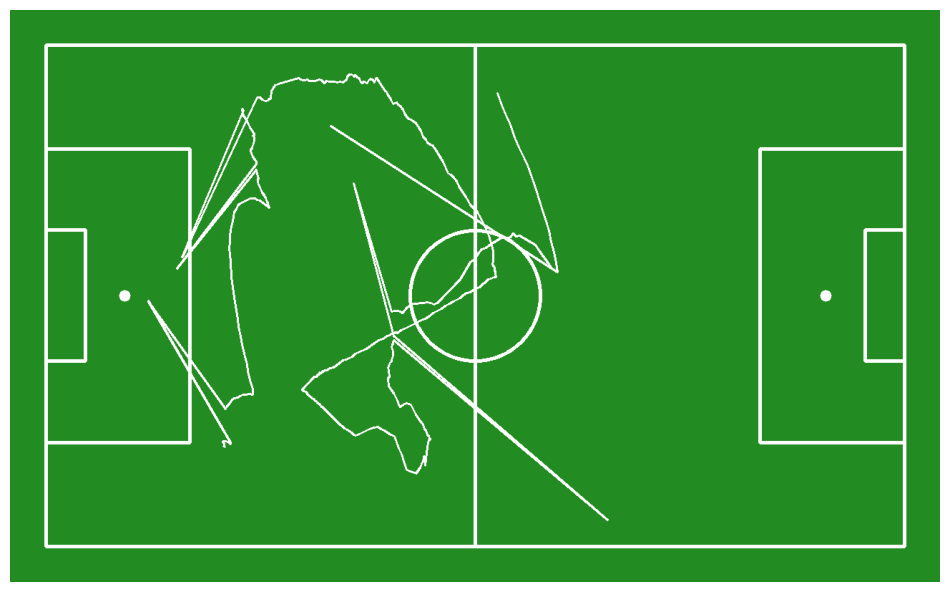

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [ ]:
from typing import List, Union

def replace_outliers_based_on_distance(
    positions: List[np.ndarray],
    distance_threshold: float
) -> List[np.ndarray]:
    last_valid_position: Union[np.ndarray, None] = None
    cleaned_positions: List[np.ndarray] = []

    for position in positions:
        if len(position) == 0:
            # If the current position is already empty, just add it to the cleaned positions
            cleaned_positions.append(position)
        else:
            if last_valid_position is None:
                # If there's no valid last position, accept the first valid one
                cleaned_positions.append(position)
                last_valid_position = position
            else:
                # Calculate the distance from the last valid position
                distance = np.linalg.norm(position - last_valid_position)
                if distance > distance_threshold:
                    # Replace with empty array if the distance exceeds the threshold
                    cleaned_positions.append(np.array([], dtype=np.float64))
                else:
                    cleaned_positions.append(position)
                    last_valid_position = position

    return cleaned_positions

In [ ]:
MAX_DISTANCE_THRESHOLD = 500

path = replace_outliers_based_on_distance(path, MAX_DISTANCE_THRESHOLD)

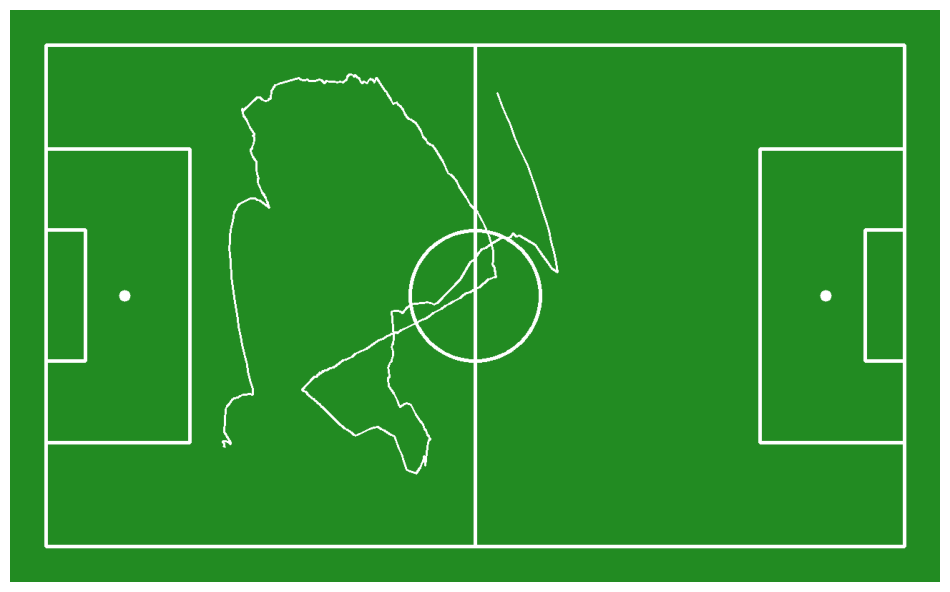

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)

In [ ]:
def interpolate_empty_positions(path: List[np.ndarray]) -> List[np.ndarray]:
    # Find indices of empty arrays
    empty_indices = [i for i, arr in enumerate(path) if arr.size == 0]

    for idx in empty_indices:
        # Find the previous non-empty array
        prev_idx = max(i for i in range(idx) if path[i].size > 0)

        # Find the next non-empty array (if it exists)
        next_indices = [i for i in range(idx + 1, len(path)) if path[i].size > 0]
        if not next_indices:
            # If no next non-empty array exists, skip interpolation
            continue

        next_idx = min(next_indices)

        # Linear interpolation between the previous and next non-empty arrays
        weight = (idx - prev_idx) / (next_idx - prev_idx)
        interpolated_value = (1 - weight) * path[prev_idx] + weight * path[next_idx]

        # Replace the empty array with the interpolated value
        path[idx] = interpolated_value

    return path

In [ ]:
path = interpolate_empty_positions(path)

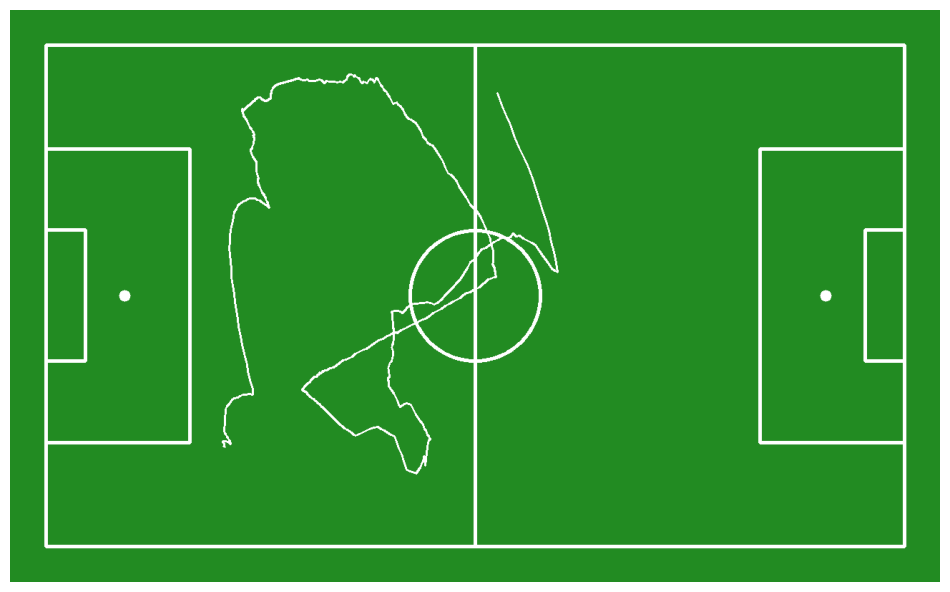

In [ ]:
from sports.annotators.soccer import draw_paths_on_pitch

annotated_frame = draw_pitch(CONFIG)
annotated_frame = draw_paths_on_pitch(
    config=CONFIG,
    paths=[path],
    color=sv.Color.WHITE,
    pitch=annotated_frame)

sv.plot_image(annotated_frame)